# Question 2: Portfolio Selection

## Part 1

1. Download **49 Industry Portfolios** data from

  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

I have downloaded the data and cleaned it up using excel so I can directly read it as `returns.csv`


## Part 2
Treat each of 49 industry portfolios as an asset and consider an
optimal portfolio selection problem with these 49 assets. Using the
monthly returns data **from January 1990 to December 2009**, draw the
efficient frontier for

  + minimum variance portfolio problem
  + minimum mean absolute deviation portfolio problem
  + minimum semi-variance portfolio problem
  + optimal expected shortfall portfolio problem

with the short selling constraint.

In [9]:
import numpy as np
import cvxpy as cp
import pandas as pd
import numpy.linalg as la
import scipy.optimize as opt
import matplotlib.pyplot as plt
from IPython.display import display

# Read the cleaned up Fama-French data (returns.csv)
R = pd.read_csv('returns.csv', index_col=0)

# Change the index to be dates January 1990 to December 2009
R.index = pd.date_range('1990-01-01', periods=R.shape[0], freq='M')

# Get the number of periods (T) and number of assets (N)
T, N = R.shape
# Compute the mean return for each asset
Mu = R.mean().values

# Show the head of the returns data
R.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1990-01-31,-11.45,-10.13,-10.63,-9.03,-8.65,-11.38,-10.74,-9.26,-7.72,-9.15,...,-3.45,-7.61,-7.67,-5.63,-11.41,-9.73,-10.60,-7.61,-8.25,-9.38
1990-02-28,9.40,-0.80,-0.89,0.51,-2.56,0.63,1.79,0.28,0.17,2.67,...,3.71,5.93,2.13,2.22,-0.99,3.94,1.42,0.40,0.87,1.88
1990-03-31,2.69,5.29,9.89,6.21,6.81,6.75,1.09,-0.86,4.18,8.19,...,4.34,3.26,2.99,6.04,0.66,-2.97,0.13,4.80,-2.10,4.53
1990-04-30,-2.04,0.02,-4.74,2.32,4.77,-5.90,1.14,-7.23,-1.89,-0.94,...,2.19,-4.20,-2.18,-1.72,-3.94,-4.38,-4.48,-4.73,-3.39,4.00
1990-05-31,1.44,9.22,8.36,15.91,1.12,12.39,13.21,10.07,9.78,8.20,...,4.66,4.87,9.11,11.99,13.75,10.57,10.47,-0.10,4.32,11.57


### Minimum variance frontier

In [10]:
T, N = R.shape
Mu = R.mean().values
Sigma = R.cov().values * ((T - 1.0) / T)
Return_Dev = (R - Mu).values

In [11]:
# Define the problem

Weight = cp.Variable(N)
Deviation = cp.Variable(T)
Target_Return = cp.Parameter()
Risk_Variance = cp.sum_squares(Deviation) / T
Opt_Portfolio = cp.Problem(cp.Minimize(Risk_Variance),
                           [Return_Dev @ Weight == Deviation,
                            Weight.T @ Mu == Target_Return,
                            cp.sum(Weight) == 1.0,
                            Weight >= 0.0])

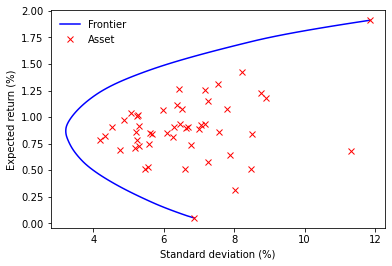

In [12]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=100)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cp.OSQP)
    V_Risk[idx] = np.sqrt(Risk_Variance.value)
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Standard deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

### Minimum mean absolute deviation frontier

In [5]:
# Define problem

Return_Dev = (R - Mu).values
Weight = cp.Variable(N)
Deviation = cp.Variable(T)
Target_Return = cp.Parameter()
Risk_AD = cp.norm(Deviation, 1) / T
Portfolio_AD = cp.Problem(cp.Minimize(Risk_AD),
                          [Return_Dev @ Weight == Deviation,
                           Weight.T @ Mu == Target_Return,
                           cp.sum(Weight) == 1.0,
                           Weight >= 0.0])

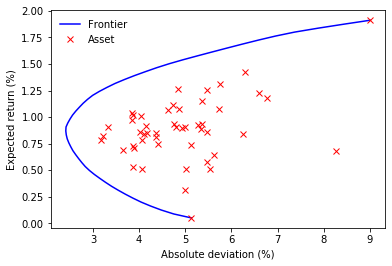

In [6]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=51)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Portfolio_AD.solve(solver=cp.ECOS)
    V_Risk[idx] = Risk_AD.value
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot((R - Mu).abs().mean().values, Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Absolute deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

### Minimum semi-variance frontier

In [11]:
Return_Dev = (R - Mu).values
Weight = cp.Variable(N)
Deviation = cp.Variable(T)
Target_Return = cp.Parameter()
Risk_Semivariance = cp.sum_squares(Deviation) / T
Portfolio_SV = cp.Problem(cp.Minimize(Risk_Semivariance),
                          [Weight.T @ Mu == Target_Return,
                           cp.sum(Weight) == 1.0,
                           Weight >= 0.0,
                           Deviation >= 0.0,
                           Return_Dev @ Weight + Deviation >= 0.0])

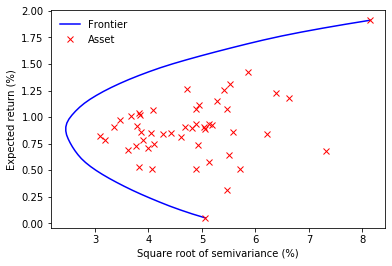

In [12]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=51)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Portfolio_SV.solve(solver=cp.ECOS)
    V_Risk[idx] = np.sqrt(Risk_Semivariance.value)
fig2 = plt.figure(num=2, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot(np.sqrt(((R[R <= Mu] - Mu) ** 2).sum().values / T), Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Square root of semivariance (%)')
plt.ylabel('Expected return (%)')
plt.show()

### Optimal expected shortfall frontier

In [13]:
Return = R.values
Weight = cp.Variable(N)
Deviation = cp.Variable(T)
VaR = cp.Variable()
inv_Alpha = cp.Parameter(nonneg=True)
Target_Return = cp.Parameter()
Risk_ES = cp.sum(Deviation) * inv_Alpha / T - VaR
Portfolio_ES = cp.Problem(cp.Minimize(Risk_ES),
                          [Weight.T @ Mu == Target_Return,
                           cp.sum(Weight) == 1.0,
                           Weight >= 0.0,
                           Deviation >= 0.0,
                           Return @ Weight - VaR + Deviation >= 0.0])

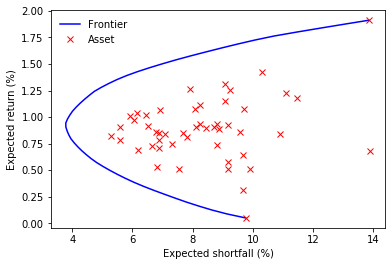

In [14]:
Alpha = 0.2
inv_Alpha.value = 1.0 / Alpha
V_Target = np.linspace(Mu.min(), Mu.max(), num=51)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Portfolio_ES.solve(solver=cp.ECOS)
    V_Risk[idx] = Risk_ES.value
fig3 = plt.figure(num=3, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot((-R[R <= R.quantile(Alpha)]).mean().values, Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Expected shortfall (%)')
plt.ylabel('Expected return (%)')
plt.show()

## Part 3

Compute allocation weights of the following portfolios:

  + equal-weight portfolio
  + global minimum variance portfolio
  + risk parity portfolio
  + maximum diversification portfolio

They are based on the covariance matrix estimated with the data **from January 1990 to December 2009**.

### Equal-weight portfolio

The equal-weight portfolio assigns an equal weight to each asset. Since the sum of all the weights is 1, this just means that each asset has a weight of

\begin{equation*}
w_n = \frac{1}{N}
\end{equation*}

In [36]:
# Equal-weight portfolio weights
Weight_1N = np.tile(1.0/Mu.shape[0], Mu.shape[0])
Weight_1N

array([   0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02,
          0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02,
          0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02,
          0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02,
          0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02,
          0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02,
          0.02,    0.02,    0.02,    0.02,    0.02,    0.02,    0.02])

### Global minimum variance portfolio

In [40]:
# Some of these are negative, which is either fine because short selling is allowed or a huge problem because it's not
# Even if it is, the sheer number that it says to sell short seems excessive
# So I suspect that something is wrong here

iota = np.ones(Mu.shape)
inv_Sigma = la.inv(Sigma)

Weight_MV = inv_Sigma @ iota / (iota @ inv_Sigma @ iota)
Weight_MV

array([   0.08,    0.05,    0.01,   -0.02,   -0.01,    0.02,   -0.03,
          0.14,    0.18,   -0.07,   -0.06,    0.05,    0.08,   -0.15,
         -0.06,   -0.04,   -0.08,   -0.12,   -0.10,    0.04,   -0.11,
         -0.06,   -0.05,   -0.13,   -0.02,    0.13,    0.02,    0.05,
         -0.01,    0.18,    0.33,    0.08,    0.03,   -0.08,    0.09,
         -0.10,    0.09,   -0.04,    0.23,    0.10,    0.15,    0.06,
          0.25,    0.03,   -0.10,   -0.15,    0.06,    0.01,    0.02])

### Risk parity portfolio

In [38]:
F = lambda v, Sigma: np.hstack((Sigma @ v[:-1] - v[-1]/v[:-1], v[:-1].sum() - 1.0))
Weight_RP = opt.root(F, np.hstack((Weight_1N, 0.0)), args=Sigma).x[:-1]
Weight_RP

array([   0.12,    0.20,    0.17,   -0.34,   -0.16,    0.16,   -0.16,
          0.44,    0.29,   -0.23,   -0.24,    0.17,    0.15,   -0.43,
         -0.28,   -0.12,   -0.15,   -0.24,   -0.22,    0.22,   -0.25,
         -0.15,   -0.19,   -0.25,   -0.16,    0.22,    0.06,    0.20,
         -0.06,    0.30,    0.28,    0.20,    0.13,   -0.55,    0.25,
         -0.37,    0.26,   -0.28,    0.53,    0.25,    0.31,    0.26,
          0.30,    0.25,   -0.39,   -0.35,    0.18,    0.38,    0.28])

### Maximum diversification portfolio

In [39]:
# Compute sample standard deviation of the returns
Stdev = R.std() * (T-1)/T

Weight_MD = inv_Sigma @ Stdev / (iota @ inv_Sigma @ Stdev)
Weight_MD

array([   0.18,   -0.14,    0.14,    0.11,    0.16,    0.13,   -0.02,
          0.11,    0.05,   -0.03,    0.10,   -0.24,    0.13,   -0.28,
         -0.23,    0.12,   -0.16,   -0.18,   -0.07,    0.12,   -0.48,
         -0.02,    0.00,   -0.13,    0.07,    0.24,    0.17,    0.02,
          0.16,    0.12,    0.22,    0.19,    0.09,   -0.57,    0.20,
          0.07,    0.16,    0.25,    0.17,    0.17,    0.06,   -0.58,
          0.33,   -0.07,    0.01,   -0.01,    0.16,   -0.12,    0.09])

## Part 4

Compare the performance of the above portfolios in the buy-and-hold strategy **from January 2010 to December 2019**

For this, I made a new file `returns_out_of_sample.csv` for the 2010 to 2019 period.

In [43]:
# Read the out of sample data as R_pred
R_pred = pd.read_csv('returns_out_of_sample.csv',index_col=0)

R_pred.index = pd.date_range('2010-01-01', periods=R_pred.shape[0], freq='M')

R_pred.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2010-01-31,-6.64,0.60,-2.42,-3.70,-3.35,-2.32,2.34,3.55,0.85,-3.11,...,-8.64,-4.04,-2.55,-1.92,-0.98,0.44,0.73,-5.02,-7.99,3.54
2010-02-28,-6.60,3.26,13.70,0.25,4.43,14.52,3.15,-3.01,3.69,6.07,...,7.90,7.25,5.89,4.32,4.50,1.81,3.51,7.32,3.91,1.06
2010-03-31,2.04,4.46,8.20,6.11,6.12,6.57,14.13,5.47,2.13,11.39,...,6.06,8.11,5.99,6.14,8.27,8.46,8.10,14.73,6.96,9.82
2010-04-30,-10.17,0.18,-1.73,-1.76,-2.51,-0.90,15.13,2.31,1.21,4.23,...,1.84,3.82,3.20,1.85,7.31,3.05,-1.67,6.05,-1.45,3.81
2010-05-31,-18.19,-3.86,-0.22,-3.88,-7.69,-5.69,-7.47,-10.35,-4.35,-5.67,...,-8.49,-5.98,-4.01,-5.83,-4.76,-11.00,-5.88,-11.24,-8.15,-10.95


In [54]:
# These next two cells are probably not the most efficient way to do things, but do get the job down

# Calculate average returns for the equal-weight portfolio
equal_wt = np.sum(Weight_1N*R_pred,axis=1).mean()
print('Average returns for the equal-weight portfolio: ',np.round(equal_wt,3))

# Calculate average returns for the global minimum variance portfolio
min_var = np.sum(Weight_MV*R_pred,axis=1).mean()
print('Average returns for the global minimum variance portfolio: ',np.round(min_var,3))

# Calculate average returns for the risk parity portfolio
risk_par = np.sum(Weight_RP*R_pred,axis=1).mean()
print('Average returns for the risk parity portfolio: ',np.round(risk_par,3))

# Calculate average returns for the maximum diversification portfolio
max_div = np.sum(Weight_MD*R_pred,axis=1).mean()
print('Average returns for the maximum diversification portfolio: ',np.round(risk_par,3))

Average returns for the equal-weight portfolio:  1.067
Average returns for the global minimum variance portfolio:  0.739
Average returns for the risk parity portfolio:  -0.112
Average returns for the maximum diversification portfolio:  -0.112


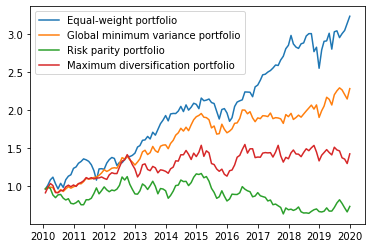

In [60]:
# Convert returns to gross growth rates
equal_wt_return = np.sum(Weight_1N*R_pred,axis=1)/100+1
min_var_return = np.sum(Weight_MV*R_pred,axis=1)/100+1
risk_par_return = np.sum(Weight_RP*R_pred,axis=1)/100+1
max_div_return = np.sum(Weight_MD*R_pred,axis=1)/100+1

# Calculate the cumulative products
plt.plot(np.cumprod(equal_wt_return),label='Equal-weight portfolio')
plt.plot(np.cumprod(min_var_return),label='Global minimum variance portfolio')
plt.plot(np.cumprod(risk_par_return),label='Risk parity portfolio')
plt.plot(np.cumprod(max_div_return),label='Maximum diversification portfolio')
plt.legend()